In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
MEDford_df = pd.read_csv('MEdford_US_Data_2015-2018_EDITED.csv') 
MEDford_df = MEDford_df.dropna()
MEDford_df

Year  Month  Day  Hour  Minute  GHI  Clearsky GHI  Cloud Type  \
0      2015      1    1     0      30    0             0           0   
1      2015      1    1     1      30    0             0           0   
2      2015      1    1     2      30    0             0           0   
3      2015      1    1     3      30    0             0           0   
4      2015      1    1     4      30    0             0           0   
...     ...    ...  ...   ...     ...  ...           ...         ...   
35035  2018     12   31    19      30    0             0           7   
35036  2018     12   31    20      30    0             0           7   
35037  2018     12   31    21      30    0             0           7   
35038  2018     12   31    22      30    0             0           4   
35039  2018     12   31    23      30    0             0           7   

       Wind Speed  Relative Humidity  Temperature  Pressure  
0             0.4              85.18         -1.0       970  
1             0.4              83.54         -1.0       970  
2             0.4              82.07         -1.0       970  
3             0.4              80.75         -1.0       970  
4             0.4              79.63         -2.0       970  
...           ...                ...          ...       ...  
35035         0.5              81.77          7.9       967  
35036         0.5              81.06          7.9       968  
35037         0.6              79.58          8.2       969  
35038         0.6              78.96          8.4       969  
35039         0.7              79.82          8.2       969  

[35040 rows x 12 columns]

In [3]:
MEDford_df_new = MEDford_df.copy()

MEDford_df_new['DateTime'] = MEDford_df[['Year', 'Month', 'Day', 'Hour']].apply(lambda s : datetime.datetime(*s),axis = 1)
MEDford_df_new = MEDford_df_new.drop(columns = ['Year','Minute'])
MEDford_df_new['DateTime'] = pd.to_datetime(MEDford_df_new['DateTime']) 
MEDford_df_new.set_index(['DateTime'], drop=True, inplace=True)
MEDford_df_new

Month  Day  Hour  GHI  Clearsky GHI  Cloud Type  \
DateTime                                                               
2015-01-01 00:00:00      1    1     0    0             0           0   
2015-01-01 01:00:00      1    1     1    0             0           0   
2015-01-01 02:00:00      1    1     2    0             0           0   
2015-01-01 03:00:00      1    1     3    0             0           0   
2015-01-01 04:00:00      1    1     4    0             0           0   
...                    ...  ...   ...  ...           ...         ...   
2018-12-31 19:00:00     12   31    19    0             0           7   
2018-12-31 20:00:00     12   31    20    0             0           7   
2018-12-31 21:00:00     12   31    21    0             0           7   
2018-12-31 22:00:00     12   31    22    0             0           4   
2018-12-31 23:00:00     12   31    23    0             0           7   

                     Wind Speed  Relative Humidity  Temperature  Pressure  
DateTime                                                                   
2015-01-01 00:00:00         0.4              85.18         -1.0       970  
2015-01-01 01:00:00         0.4              83.54         -1.0       970  
2015-01-01 02:00:00         0.4              82.07         -1.0       970  
2015-01-01 03:00:00         0.4              80.75         -1.0       970  
2015-01-01 04:00:00         0.4              79.63         -2.0       970  
...                         ...                ...          ...       ...  
2018-12-31 19:00:00         0.5              81.77          7.9       967  
2018-12-31 20:00:00         0.5              81.06          7.9       968  
2018-12-31 21:00:00         0.6              79.58          8.2       969  
2018-12-31 22:00:00         0.6              78.96          8.4       969  
2018-12-31 23:00:00         0.7              79.82          8.2       969  

[35040 rows x 10 columns]

Text(0, 0.5, 'GHI ($w/m^2$)')

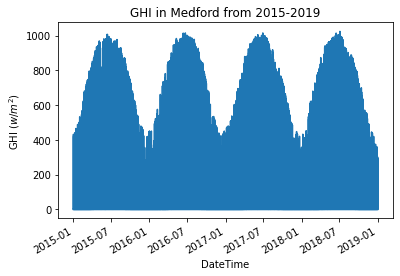

In [4]:
GHI = MEDford_df_new['GHI']
GHI.plot()
plt.title('GHI in Medford from 2015-2019')
plt.ylabel('GHI ($w/m^2$)')

In [5]:
def df_to_X_y_24(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(0, df.shape[0]-window_size-24):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size+24,3]
        y.append(label)
    return np.array(X), np.array(y)

In [6]:
window_size = 24
X,y = df_to_X_y_24(MEDford_df_new, 24)
m,n = X.shape[::3]
X = np.rollaxis(X,3,1).reshape(m,-1,n)
X.shape

(34992, 24, 10)

In [7]:
X_train, X_test, Y_train, Y_test = X[:26244],X[26244:], y[:26244], y[26244:] # Testing: from 30/12/2017 - 31/ 12/ 2018
print('Shape of X_train set:',X_train.shape) 
print('Shape of Y_train set:',Y_train.shape)
print('Shape of X_test set:',X_test.shape)
print('Shape of Y_test set:',Y_test.shape)

Shape of X_train set: (26244, 24, 10)
Shape of Y_train set: (26244,)
Shape of X_test set: (8748, 24, 10)
Shape of Y_test set: (8748,)


In [8]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((24,10)))
model.add(GRU(100))
model.add(Dense(10,'relu'))
model.add(Dense(1,'linear'))

model.summary()

C:\Users\Hamza\anaconda3\envs\ml_proj\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               33600     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 34,621
Trainable params: 34,621
Non-trainable params: 0
_________________________________________________________________


In [9]:
cp = ModelCheckpoint('model2/',save_best_only =True)
model.compile(loss = MeanSquaredError() , optimizer = Adam(learning_rate = 0.0001), metrics = RootMeanSquaredError())

In [10]:
import timeit
start  = timeit.default_timer()
model.fit(X_train,Y_train, epochs = 30, callbacks = [cp])
stop = timeit.default_timer()
print('Time: ', stop - start)

Epoch 1/30
821/821 [==============================] - 14s 13ms/step - loss: 107506.0938 - root_mean_squared_error: 327.8812
Epoch 2/30
821/821 [==============================] - 11s 13ms/step - loss: 101694.3047 - root_mean_squared_error: 318.8954
Epoch 3/30
821/821 [==============================] - 11s 13ms/step - loss: 95266.7656 - root_mean_squared_error: 308.6531
Epoch 4/30
821/821 [==============================] - 11s 13ms/step - loss: 86750.3203 - root_mean_squared_error: 294.5341
Epoch 5/30
821/821 [==============================] - 11s 13ms/step - loss: 76900.1875 - root_mean_squared_error: 277.3088
Epoch 6/30
821/821 [==============================] - 11s 13ms/step - loss: 67570.3828 - root_mean_squared_error: 259.9430
Epoch 7/30
821/821 [==============================] - 10s 13ms/step - loss: 58786.5469 - root_mean_squared_error: 242.4594
Epoch 8/30
821/821 [==============================] - 10s 13ms/step - loss: 50619.6367 - root_mean_squared_error: 224.9881
Epoch 9/30
821

Epoch 28/30
821/821 [==============================] - 11s 13ms/step - loss: 7432.9102 - root_mean_squared_error: 86.2143
Epoch 29/30
821/821 [==============================] - 11s 13ms/step - loss: 7513.6118 - root_mean_squared_error: 86.6811
Epoch 30/30
821/821 [==============================] - 11s 13ms/step - loss: 7359.4834 - root_mean_squared_error: 85.7874
Time:  324.1190302


#### Comparision between Actual and Train predictions - GRU

In [11]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data = {'Train prediction':train_predictions,'Actual':Y_train }, index = MEDford_df_new.index[:26244])
train_results

821/821 [==============================] - 5s 5ms/step


Train prediction  Actual
DateTime                                     
2015-01-01 00:00:00         10.799534     0.0
2015-01-01 01:00:00          5.135784     0.0
2015-01-01 02:00:00         -1.033406     0.0
2015-01-01 03:00:00          1.915088     0.0
2015-01-01 04:00:00          0.559436     0.0
...                               ...     ...
2017-12-30 07:00:00          7.780765     0.0
2017-12-30 08:00:00        108.165100    55.0
2017-12-30 09:00:00        174.946671   110.0
2017-12-30 10:00:00        206.456085   153.0
2017-12-30 11:00:00        299.868500   157.0

[26244 rows x 2 columns]

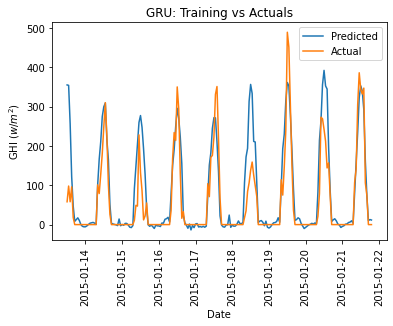

In [12]:
plt.plot(train_results['Train prediction'][300:500], label = 'Predicted')
plt.plot(train_results['Actual'][300:500], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('GRU: Training vs Actuals')
_=plt.xticks(rotation = 90)
plt.legend()

#### Comparision between Actual and Test predictions - GRU

In [13]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data = {'Test prediction':test_predictions,'Actual':Y_test },index = MEDford_df_new.index[26292:])
test_results

274/274 [==============================] - 1s 5ms/step


Test prediction  Actual
DateTime                                    
2018-01-01 12:00:00       291.191711   167.0
2018-01-01 13:00:00       248.502060   175.0
2018-01-01 14:00:00       196.079056   151.0
2018-01-01 15:00:00       148.386154    73.0
2018-01-01 16:00:00        12.195965    13.0
...                              ...     ...
2018-12-31 19:00:00        -3.662800     0.0
2018-12-31 20:00:00        -0.871426     0.0
2018-12-31 21:00:00         1.956874     0.0
2018-12-31 22:00:00        10.723209     0.0
2018-12-31 23:00:00        -2.985493     0.0

[8748 rows x 2 columns]

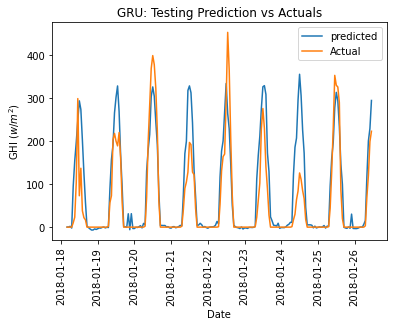

In [14]:
plt.plot(test_results['Test prediction'][400:600],label = 'predicted')
plt.plot(test_results['Actual'][400:600], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('GRU: Testing Prediction vs Actuals')
_=plt.xticks(rotation = 90)
plt.legend()

In [15]:
from sklearn.metrics import r2_score
print('Training score:', r2_score(Y_train, train_results['Train prediction'] ))
print('Testing score:', r2_score(test_results['Actual'], test_results['Test prediction']))


Training score: 0.9036075401243954
Testing score: 0.8968884898521327


## Scenario 2

##### Winter: 12 ,1 ,2 
##### Spring: 3,4,5
##### Summer: 6,7,8
##### Fall : 9,10,11

In [16]:
Fall_GRU = test_results['2018-9-1 01:00:00': '2018-11-30 23:00:00']
Spring_GRU =test_results['2018-3-1 01:00:00': '2018-5-31 23:00:00']
Summer_GRU = test_results['2018-6-1 01:00:00': '2018-8-31 23:00:00']
W = test_results['2018-1-1 01:00:00': '2018-2-28 23:00:00']
W.values.tolist()
Winter_GRU = W.append(test_results['2018-12-1 01:00:00': '2018-12-31 23:00:00'])
Winter_GRU

C:\Users\Hamza\AppData\Local\Temp\ipykernel_23336\791558911.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Winter_GRU = W.append(test_results['2018-12-1 01:00:00': '2018-12-31 23:00:00'])


Test prediction  Actual
DateTime                                    
2018-01-01 12:00:00       291.191711   167.0
2018-01-01 13:00:00       248.502060   175.0
2018-01-01 14:00:00       196.079056   151.0
2018-01-01 15:00:00       148.386154    73.0
2018-01-01 16:00:00        12.195965    13.0
...                              ...     ...
2018-12-31 19:00:00        -3.662800     0.0
2018-12-31 20:00:00        -0.871426     0.0
2018-12-31 21:00:00         1.956874     0.0
2018-12-31 22:00:00        10.723209     0.0
2018-12-31 23:00:00        -2.985493     0.0

[2147 rows x 2 columns]

In [17]:
%store Fall_GRU
%store Spring_GRU
%store Summer_GRU
%store Winter_GRU

Stored 'Fall_GRU' (DataFrame)
Stored 'Spring_GRU' (DataFrame)
Stored 'Summer_GRU' (DataFrame)
Stored 'Winter_GRU' (DataFrame)


#### Winter

LSTM Winter Testing score: 0.7208493052722644


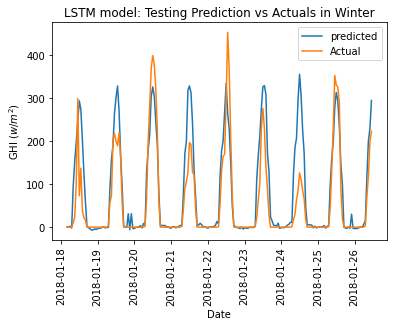

In [19]:
plt.plot(Winter_GRU['Test prediction'][400:600],label = 'predicted')
plt.plot(Winter_GRU['Actual'][400:600], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('LSTM model: Testing Prediction vs Actuals in Winter')
_=plt.xticks(rotation = 90)
plt.legend()
print('LSTM Winter Testing score:', r2_score(Winter_GRU['Actual'], Winter_GRU['Test prediction']))

#### Summer

LSTM Summer Testing score: 0.9538637943915981


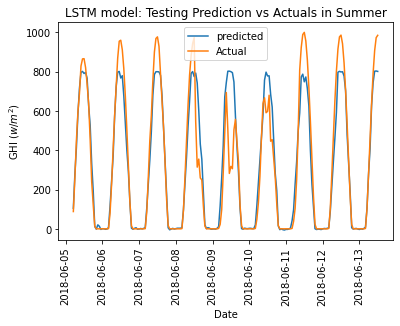

In [20]:
plt.plot(Summer_GRU['Test prediction'][100:300],label = 'predicted')
plt.plot(Summer_GRU['Actual'][100:300], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('LSTM model: Testing Prediction vs Actuals in Summer')
_=plt.xticks(rotation = 90)
plt.legend()
print('LSTM Summer Testing score:', r2_score(Summer_GRU['Actual'], Summer_GRU['Test prediction']))

#### Spring

LSTM Spring Testing score: 0.8120480225176638


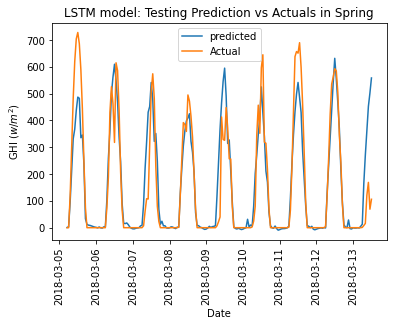

In [21]:
plt.plot(Spring_GRU['Test prediction'][100:300],label = 'predicted')
plt.plot(Spring_GRU['Actual'][100:300], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('LSTM model: Testing Prediction vs Actuals in Spring')
_=plt.xticks(rotation = 90)
plt.legend()
print('LSTM Spring Testing score:', r2_score(Spring_GRU['Actual'], Spring_GRU['Test prediction']))

#### Fall

LSTM Fall Testing score: 0.8973769125964152


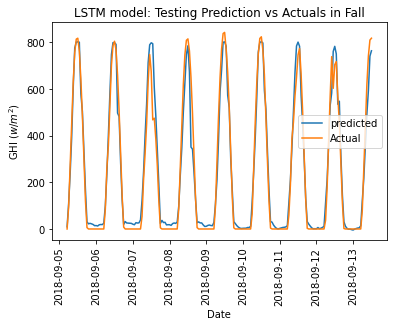

In [22]:
plt.plot(Fall_GRU['Test prediction'][100:300],label = 'predicted')
plt.plot(Fall_GRU['Actual'][100:300], label = 'Actual')
plt.xlabel('Date')
plt.ylabel('GHI ($w/m^2$)')
plt.title('LSTM model: Testing Prediction vs Actuals in Fall')
_=plt.xticks(rotation = 90)
plt.legend()
print('LSTM Fall Testing score:', r2_score(Fall_GRU['Actual'], Fall_GRU['Test prediction']))